# Laboratorio RNN

## Autores:

- Juan Sebastián Vargas

## Test

In [ ]:
from keras.preprocessing.text import Tokenizer
samples = ['The cat sat on the mat.', 'The dog ate my homework.']
tokenizer = Tokenizer(num_words=1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
one_hot_results = tokenizer.texts_to_matrix(samples, mode='binary')
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9 unique tokens.


## Imports

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import os
import time
import matplotlib.pyplot as plt
import re
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Reading Data

In [ ]:
# Leemos el archivo a una variable texto
simpsons_text = open("/content/summary.txt", 'rb').read().decode(encoding='utf-8')
# La longitud del string nos dice el número de caracteres
print(f'Length of text: {len(simpsons_text)} characters')

Length of text: 1465471 characters


In [ ]:
print(simpsons_text[:5000])


> Quotes and Scene Summary
% [Syndication cuts are marked in curly braces "{}" and are courtesy of
% Ricardo Lafaurie and Frederic Briere.]
%
% It's another lazy day at the Springfield Nuclear Power Plant.  Homer
% sits snoring at his desk, his old, faithful dog snoozing in a chair
% next to him.  Lenny has craftily constructed a hammock for himself in
% another room.
%
% In his sleep, Homer rests his head on the control panel in front of
% him -- directly on the "PLANT DESTRUCT: PLEASE DO NOT PUSH" button.
% The control room becomes awash in the red glow of emergency lights,
% and the automated female voice says, "Core meltdown in ten seconds...
% nine..." Homer's dog wakes up, hears the voice, and pulls the reset
% lever with his mouth.  The voice announces, "Meltdown averted...good
% boy."
%
% Mr. Burns, too, is asleep in his chair, its back to his wall of
% monitors.  Yes, even the people on the monitors are asleep too.
% Smithers sleeps, curled up beside Burns' chair.  His leg tw

In [ ]:
print(len(simpsons_text))

1465471


## Creating vocabulary

In [ ]:
def extract_words(string):
    # Define a regular expression to match any sequence of one or more characters
    pattern = re.compile(r'\S+')
    # Use the findall() method to extract all words from the string and return them as a set
    return sorted(set(pattern.findall(string)))


In [ ]:
#vocab = extract_words(simpsons_text)
vocab = simpsons_text.split(' ')

In [ ]:
vocab[:5]

['\n>',
 'Quotes',
 'and',
 'Scene',
 'Summary\n===============================================================================\n%']

In [ ]:
simpson_vocab = vocab
print(f'{len(simpson_vocab)} unique words')

317132 unique words


In [ ]:
vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=None,
    split=None,
    output_mode='int',
    encoding='utf-8'
)

In [ ]:
vectorize_layer.adapt(simpsons_text.split(' '))

In [ ]:
vectorize_data= vectorize_layer(simpsons_text)

In [ ]:
vectorize_data

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [ ]:
vocabulary = vectorize_layer.get_vocabulary()

In [ ]:
vocabulary

['',
 '[UNK]',
 'the',
 'a',
 'to',
 'and',
 'of',
 'I',
 'in',
 'you',
 'on',
 'is',
 'with',
 'his',
 'for',
 'at',
 'it',
 'that',
 'The',
 'Homer',
 'Bart:',
 'my',
 'your',
 'have',
 "I'm",
 'Bart',
 'he',
 'out',
 'Homer:',
 'be',
 'this',
 'are',
 'Lisa:',
 'all',
 'but',
 'as',
 'Oh,',
 '--',
 'up',
 'just',
 'from',
 'like',
 'we',
 'was',
 'You',
 "don't",
 'into',
 'me',
 'get',
 'an',
 'one',
 'can',
 'not',
 'Marge',
 'do',
 'going',
 "it's",
 'by',
 'Well,',
 'He',
 'they',
 'And',
 'some',
 'her',
 'Lisa',
 'Mr.',
 'him',
 'what',
 'about',
 'got',
 'A',
 'has',
 'so',
 '"Homer',
 'back',
 "It's",
 'But',
 'off',
 "I'll",
 'down',
 'walks',
 'go',
 'Marge:',
 'over',
 'the\n',
 'their',
 'our',
 'want',
 'little',
 'no',
 'the\n%',
 'know',
 "you're",
 'then',
 '--\n',
 'think',
 'if',
 'Homer,',
 'will',
 "can't",
 '"The',
 'who',
 "That's",
 'At',
 'What',
 'see',
 'man',
 'only',
 'she',
 'It',
 'Bart,',
 'been',
 'them',
 'it,',
 'when',
 'take',
 'a\n',
 'two',
 'He

In [ ]:
def words_from_ids(id):
  try:
    return(vocabulary[id.numpy()])
  except:
    return(vocabulary[id])

In [ ]:
vectorize_layer(["Summary\n===============================================================================\n%"]).numpy()

array([464])

In [ ]:
vectorize_layer("Bart:")

<tf.Tensor: shape=(), dtype=int64, numpy=20>

In [ ]:
vectorize_layer(["[UNK]"])[:, None]

<tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[1]])>

In [ ]:
words_from_ids(12337)

'Yeah.\n--'

In [ ]:
words_from_ids(11)

'is'

In [ ]:
def text_from_ids(sequence):
  text = []
  for i in sequence:
    text.append(words_from_ids(i))
  return tf.strings.reduce_join(text, axis=-1, separator=' ')

In [ ]:
all_ids = vectorize_layer(simpsons_text.split(' '))
all_ids

<tf.Tensor: shape=(317132,), dtype=int64, numpy=array([44602,   451,     5, ...,     0,   147, 43147])>

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
ids_dataset

<TensorSliceDataset element_spec=TensorSpec(shape=(), dtype=tf.int64, name=None)>

In [ ]:
seq_length = 100
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

In [ ]:
for seq in sequences.take(5):
  print(seq)
  print(text_from_ids(seq))
  print("-"*50)

tf.Tensor(
[44602   451     5   450   464   541   438    31   516     8   537   538
   547     5    31   505   226   922  1149     5   569   622    75   181
  6815   250    15     2   136  2154  4650 12631     0   955   299 17969
    15    13 11174    13  3111  7094   536 17971     8     3 32029   120
     4   503     0   821    71 30835 31129     3  6963    14   655   448
   181  6461   144    13  4972    19  6483    13   212    10     2  1127
  5130     8   151   226    66    37  3707    10     2 44042 41546 38502
 13149 38873 38498 32495    18  1127   361  1429 33980     8     2   612
  7000     6  2288 24266     5], shape=(101,), dtype=int64)
tf.Tensor(b'\n> Quotes and Scene Summary\n===============================================================================\n% [Syndication cuts are marked in curly braces "{}" and are courtesy of\n% Ricardo Lafaurie and Frederic Briere.]\n%\n% It\'s another lazy day at the Springfield Nuclear Power Plant.  Homer\n% sits snoring at his desk, his

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(2):
  print("Input :", text_from_ids(input_example).numpy())
  print("Target:", text_from_ids(target_example).numpy())

Input : b'\n> Quotes and Scene Summary\n===============================================================================\n% [Syndication cuts are marked in curly braces "{}" and are courtesy of\n% Ricardo Lafaurie and Frederic Briere.]\n%\n% It\'s another lazy day at the Springfield Nuclear Power Plant.  Homer\n% sits snoring at his desk, his old, faithful dog snoozing in a chair\n% next to him.  Lenny has craftily constructed a hammock for himself in\n% another room.\n%\n% In his sleep, Homer rests his head on the control panel in front of\n% him -- directly on the "PLANT DESTRUCT: PLEASE DO NOT PUSH" button.\n% The control room becomes awash in the red glow of emergency lights,\n%'
Target: b'Quotes and Scene Summary\n===============================================================================\n% [Syndication cuts are marked in curly braces "{}" and are courtesy of\n% Ricardo Lafaurie and Frederic Briere.]\n%\n% It\'s another lazy day at the Springfield Nuclear Power Plant.  Homer\n

In [ ]:
# Batch size
BATCH_SIZE = 32

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset element_spec=(TensorSpec(shape=(32, 100), dtype=tf.int64, name=None), TensorSpec(shape=(32, 100), dtype=tf.int64, name=None))>

## Training

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(vectorize_layer.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
model = keras.Sequential()

model.add(layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim))

model.add(tf.keras.layers.LSTM(rnn_units,
                                   return_sequences=True))

model.add(tf.keras.layers.Dense(vocab_size))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         11418368  
                                                                 
 lstm (LSTM)                 (None, None, 1024)        5246976   
                                                                 
 dense (Dense)               (None, None, 44603)       45718075  
                                                                 
Total params: 62,383,419
Trainable params: 62,383,419
Non-trainable params: 0
_________________________________________________________________


In [ ]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [ ]:
model.compile(optimizer= Adam(), loss=loss)

In [ ]:
EPOCHS = 100

In [ ]:
# Declaración callback de EarlyStopping (si pasan más de 10 épocas y no mejora el error de validación, se para la ejecución)
callback_early = EarlyStopping(monitor='loss', mode='min', patience=5)
# Declaración callback checkpoint ( se guarda en el directorio /tmp/checkpoints el modelo con el menor error)
callback_checkpoint= ModelCheckpoint(filepath='/tmp/checkpoints',monitor='loss', mode='min',save_best_only=True)

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[callback_early, callback_checkpoint])

Epoch 1/100
98/98 [==============================] - ETA: 0s - loss: 7.5457

98/98 [==============================] - 46s 396ms/step - loss: 7.5457
Epoch 2/100
98/98 [==============================] - ETA: 0s - loss: 6.9268

98/98 [==============================] - 38s 382ms/step - loss: 6.9268
Epoch 3/100
98/98 [==============================] - ETA: 0s - loss: 6.5807

98/98 [==============================] - 38s 386ms/step - loss: 6.5807
Epoch 4/100
98/98 [==============================] - ETA: 0s - loss: 6.2112

98/98 [==============================] - 39s 390ms/step - loss: 6.2112
Epoch 5/100
98/98 [==============================] - ETA: 0s - loss: 5.8390

98/98 [==============================] - 39s 391ms/step - loss: 5.8390
Epoch 6/100
98/98 [==============================] - ETA: 0s - loss: 5.5229

98/98 [==============================] - 38s 387ms/step - loss: 5.5229
Epoch 7/100
98/98 [==============================] - ETA: 0s - loss: 5.2368

98/98 [==============================] - 39s 390ms/step - loss: 5.2368
Epoch 8/100
98/98 [==============================] - ETA: 0s - loss: 4.9896

98/98 [==============================] - 38s 385ms/step - loss: 4.9896
Epoch 9/100
98/98 [==============================] - ETA: 0s - loss: 4.7699

98/98 [==============================] - 39s 393ms/step - loss: 4.7699
Epoch 10/100
98/98 [==============================] - ETA: 0s - loss: 4.5608

98/98 [==============================] - 39s 390ms/step - loss: 4.5608
Epoch 11/100
98/98 [==============================] - ETA: 0s - loss: 4.3604

98/98 [==============================] - 38s 388ms/step - loss: 4.3604
Epoch 12/100
98/98 [==============================] - ETA: 0s - loss: 4.1704

98/98 [==============================] - 39s 389ms/step - loss: 4.1704
Epoch 13/100
98/98 [==============================] - ETA: 0s - loss: 3.9871

98/98 [==============================] - 38s 387ms/step - loss: 3.9871
Epoch 14/100
98/98 [==============================] - ETA: 0s - loss: 3.8122

98/98 [==============================] - 39s 391ms/step - loss: 3.8122
Epoch 15/100
98/98 [==============================] - ETA: 0s - loss: 3.6422

98/98 [==============================] - 38s 384ms/step - loss: 3.6422
Epoch 16/100
98/98 [==============================] - ETA: 0s - loss: 3.4744

98/98 [==============================] - 39s 392ms/step - loss: 3.4744
Epoch 17/100
98/98 [==============================] - ETA: 0s - loss: 3.3131

98/98 [==============================] - 38s 383ms/step - loss: 3.3131
Epoch 18/100
98/98 [==============================] - ETA: 0s - loss: 3.1560

98/98 [==============================] - 39s 389ms/step - loss: 3.1560
Epoch 19/100
98/98 [==============================] - ETA: 0s - loss: 3.0045

98/98 [==============================] - 39s 391ms/step - loss: 3.0045
Epoch 20/100
98/98 [==============================] - ETA: 0s - loss: 2.8593

98/98 [==============================] - 38s 386ms/step - loss: 2.8593
Epoch 21/100
98/98 [==============================] - ETA: 0s - loss: 2.7257

98/98 [==============================] - 38s 388ms/step - loss: 2.7257
Epoch 22/100
98/98 [==============================] - ETA: 0s - loss: 2.5972

98/98 [==============================] - 38s 384ms/step - loss: 2.5972
Epoch 23/100
98/98 [==============================] - ETA: 0s - loss: 2.4793

98/98 [==============================] - 39s 397ms/step - loss: 2.4793
Epoch 24/100
98/98 [==============================] - ETA: 0s - loss: 2.3677

98/98 [==============================] - 38s 388ms/step - loss: 2.3677
Epoch 25/100
98/98 [==============================] - ETA: 0s - loss: 2.2649

98/98 [==============================] - 38s 388ms/step - loss: 2.2649
Epoch 26/100
98/98 [==============================] - ETA: 0s - loss: 2.1698

98/98 [==============================] - 39s 390ms/step - loss: 2.1698
Epoch 27/100
98/98 [==============================] - ETA: 0s - loss: 2.0777

98/98 [==============================] - 38s 387ms/step - loss: 2.0777
Epoch 28/100
98/98 [==============================] - ETA: 0s - loss: 1.9935

98/98 [==============================] - 38s 388ms/step - loss: 1.9935
Epoch 29/100
98/98 [==============================] - ETA: 0s - loss: 1.9113

98/98 [==============================] - 38s 384ms/step - loss: 1.9113
Epoch 30/100
98/98 [==============================] - ETA: 0s - loss: 1.8337

98/98 [==============================] - 38s 387ms/step - loss: 1.8337
Epoch 31/100
98/98 [==============================] - ETA: 0s - loss: 1.7616

98/98 [==============================] - 38s 383ms/step - loss: 1.7616
Epoch 32/100
98/98 [==============================] - ETA: 0s - loss: 1.6917

98/98 [==============================] - 38s 388ms/step - loss: 1.6917
Epoch 33/100
98/98 [==============================] - ETA: 0s - loss: 1.6256

98/98 [==============================] - 38s 384ms/step - loss: 1.6256
Epoch 34/100
98/98 [==============================] - ETA: 0s - loss: 1.5645

98/98 [==============================] - 38s 386ms/step - loss: 1.5645
Epoch 35/100
98/98 [==============================] - ETA: 0s - loss: 1.5054

98/98 [==============================] - 38s 388ms/step - loss: 1.5054
Epoch 36/100
98/98 [==============================] - ETA: 0s - loss: 1.4465

98/98 [==============================] - 38s 384ms/step - loss: 1.4465
Epoch 37/100
98/98 [==============================] - ETA: 0s - loss: 1.3913

98/98 [==============================] - 39s 390ms/step - loss: 1.3913
Epoch 38/100
98/98 [==============================] - ETA: 0s - loss: 1.3381

98/98 [==============================] - 38s 384ms/step - loss: 1.3381
Epoch 39/100
98/98 [==============================] - ETA: 0s - loss: 1.2876

98/98 [==============================] - 39s 390ms/step - loss: 1.2876
Epoch 40/100
98/98 [==============================] - ETA: 0s - loss: 1.2375

98/98 [==============================] - 38s 384ms/step - loss: 1.2375
Epoch 41/100
98/98 [==============================] - ETA: 0s - loss: 1.1902

98/98 [==============================] - 39s 395ms/step - loss: 1.1902
Epoch 42/100
98/98 [==============================] - ETA: 0s - loss: 1.1448

98/98 [==============================] - 38s 383ms/step - loss: 1.1448
Epoch 43/100
98/98 [==============================] - ETA: 0s - loss: 1.1002

98/98 [==============================] - 38s 388ms/step - loss: 1.1002
Epoch 44/100
98/98 [==============================] - ETA: 0s - loss: 1.0595

98/98 [==============================] - 38s 382ms/step - loss: 1.0595
Epoch 45/100
98/98 [==============================] - ETA: 0s - loss: 1.0190

98/98 [==============================] - 38s 387ms/step - loss: 1.0190
Epoch 46/100
98/98 [==============================] - ETA: 0s - loss: 0.9774

98/98 [==============================] - 38s 387ms/step - loss: 0.9774
Epoch 47/100
98/98 [==============================] - ETA: 0s - loss: 0.9385

98/98 [==============================] - 38s 383ms/step - loss: 0.9385
Epoch 48/100
98/98 [==============================] - ETA: 0s - loss: 0.9026

98/98 [==============================] - 39s 391ms/step - loss: 0.9026
Epoch 49/100
98/98 [==============================] - ETA: 0s - loss: 0.8687

98/98 [==============================] - 38s 384ms/step - loss: 0.8687
Epoch 50/100
98/98 [==============================] - ETA: 0s - loss: 0.8352

98/98 [==============================] - 38s 389ms/step - loss: 0.8352
Epoch 51/100
98/98 [==============================] - ETA: 0s - loss: 0.8046

98/98 [==============================] - 39s 388ms/step - loss: 0.8046
Epoch 52/100
98/98 [==============================] - ETA: 0s - loss: 0.7714

98/98 [==============================] - 38s 387ms/step - loss: 0.7714
Epoch 53/100
98/98 [==============================] - ETA: 0s - loss: 0.7387

98/98 [==============================] - 38s 382ms/step - loss: 0.7387
Epoch 54/100
98/98 [==============================] - ETA: 0s - loss: 0.7078

98/98 [==============================] - 38s 387ms/step - loss: 0.7078
Epoch 55/100
98/98 [==============================] - ETA: 0s - loss: 0.6798

98/98 [==============================] - 38s 386ms/step - loss: 0.6798
Epoch 56/100
98/98 [==============================] - ETA: 0s - loss: 0.6521

98/98 [==============================] - 38s 383ms/step - loss: 0.6521
Epoch 57/100
98/98 [==============================] - ETA: 0s - loss: 0.6252

98/98 [==============================] - 38s 387ms/step - loss: 0.6252
Epoch 58/100
98/98 [==============================] - ETA: 0s - loss: 0.5983

98/98 [==============================] - 38s 383ms/step - loss: 0.5983
Epoch 59/100
98/98 [==============================] - ETA: 0s - loss: 0.5746

98/98 [==============================] - 38s 386ms/step - loss: 0.5746
Epoch 60/100
98/98 [==============================] - ETA: 0s - loss: 0.5514

98/98 [==============================] - 38s 383ms/step - loss: 0.5514
Epoch 61/100
98/98 [==============================] - ETA: 0s - loss: 0.5278

98/98 [==============================] - 38s 386ms/step - loss: 0.5278
Epoch 62/100
98/98 [==============================] - ETA: 0s - loss: 0.5054

98/98 [==============================] - 39s 392ms/step - loss: 0.5054
Epoch 63/100
98/98 [==============================] - ETA: 0s - loss: 0.4842

98/98 [==============================] - 38s 383ms/step - loss: 0.4842
Epoch 64/100
98/98 [==============================] - ETA: 0s - loss: 0.4636

98/98 [==============================] - 38s 387ms/step - loss: 0.4636
Epoch 65/100
98/98 [==============================] - ETA: 0s - loss: 0.4435

98/98 [==============================] - 38s 381ms/step - loss: 0.4435
Epoch 66/100
98/98 [==============================] - ETA: 0s - loss: 0.4236

98/98 [==============================] - 38s 387ms/step - loss: 0.4236
Epoch 67/100
98/98 [==============================] - ETA: 0s - loss: 0.4050

98/98 [==============================] - 38s 381ms/step - loss: 0.4050
Epoch 68/100
98/98 [==============================] - ETA: 0s - loss: 0.3884

98/98 [==============================] - 38s 387ms/step - loss: 0.3884
Epoch 69/100
98/98 [==============================] - ETA: 0s - loss: 0.3727

98/98 [==============================] - 38s 381ms/step - loss: 0.3727
Epoch 70/100
98/98 [==============================] - ETA: 0s - loss: 0.3568

98/98 [==============================] - 38s 388ms/step - loss: 0.3568
Epoch 71/100
98/98 [==============================] - ETA: 0s - loss: 0.3407

98/98 [==============================] - 38s 386ms/step - loss: 0.3407
Epoch 72/100
98/98 [==============================] - ETA: 0s - loss: 0.3264

98/98 [==============================] - 38s 384ms/step - loss: 0.3264
Epoch 73/100
98/98 [==============================] - ETA: 0s - loss: 0.3133

98/98 [==============================] - 39s 394ms/step - loss: 0.3133
Epoch 74/100
98/98 [==============================] - ETA: 0s - loss: 0.3004

98/98 [==============================] - 38s 381ms/step - loss: 0.3004
Epoch 75/100
98/98 [==============================] - ETA: 0s - loss: 0.2873

98/98 [==============================] - 38s 386ms/step - loss: 0.2873
Epoch 76/100
98/98 [==============================] - ETA: 0s - loss: 0.2732

98/98 [==============================] - 38s 382ms/step - loss: 0.2732
Epoch 77/100
98/98 [==============================] - ETA: 0s - loss: 0.2593

98/98 [==============================] - 38s 387ms/step - loss: 0.2593
Epoch 78/100
98/98 [==============================] - ETA: 0s - loss: 0.2464

98/98 [==============================] - 38s 382ms/step - loss: 0.2464
Epoch 79/100
98/98 [==============================] - ETA: 0s - loss: 0.2371

98/98 [==============================] - 38s 387ms/step - loss: 0.2371
Epoch 80/100
98/98 [==============================] - ETA: 0s - loss: 0.2276

98/98 [==============================] - 38s 385ms/step - loss: 0.2276
Epoch 81/100
98/98 [==============================] - ETA: 0s - loss: 0.2173

98/98 [==============================] - 38s 383ms/step - loss: 0.2173
Epoch 82/100
98/98 [==============================] - ETA: 0s - loss: 0.2088

98/98 [==============================] - 38s 387ms/step - loss: 0.2088
Epoch 83/100
98/98 [==============================] - ETA: 0s - loss: 0.2009

98/98 [==============================] - 38s 384ms/step - loss: 0.2009
Epoch 84/100
98/98 [==============================] - ETA: 0s - loss: 0.1936

98/98 [==============================] - 39s 396ms/step - loss: 0.1936
Epoch 85/100
98/98 [==============================] - ETA: 0s - loss: 0.1850

98/98 [==============================] - 38s 383ms/step - loss: 0.1850
Epoch 86/100
98/98 [==============================] - ETA: 0s - loss: 0.1751

98/98 [==============================] - 38s 387ms/step - loss: 0.1751
Epoch 87/100
98/98 [==============================] - ETA: 0s - loss: 0.1671

98/98 [==============================] - 38s 382ms/step - loss: 0.1671
Epoch 88/100
98/98 [==============================] - ETA: 0s - loss: 0.1620

98/98 [==============================] - 38s 388ms/step - loss: 0.1620
Epoch 89/100
98/98 [==============================] - ETA: 0s - loss: 0.1560

98/98 [==============================] - 38s 386ms/step - loss: 0.1560
Epoch 90/100
98/98 [==============================] - ETA: 0s - loss: 0.1509

98/98 [==============================] - 38s 383ms/step - loss: 0.1509
Epoch 91/100
98/98 [==============================] - ETA: 0s - loss: 0.1469

98/98 [==============================] - 38s 387ms/step - loss: 0.1469
Epoch 92/100
98/98 [==============================] - ETA: 0s - loss: 0.1399

98/98 [==============================] - 38s 384ms/step - loss: 0.1399
Epoch 93/100
98/98 [==============================] - ETA: 0s - loss: 0.1318

98/98 [==============================] - 38s 385ms/step - loss: 0.1318
Epoch 94/100
98/98 [==============================] - ETA: 0s - loss: 0.1260

98/98 [==============================] - 38s 384ms/step - loss: 0.1260
Epoch 95/100
98/98 [==============================] - ETA: 0s - loss: 0.1223

98/98 [==============================] - 39s 395ms/step - loss: 0.1223
Epoch 96/100
98/98 [==============================] - ETA: 0s - loss: 0.1200

98/98 [==============================] - 38s 388ms/step - loss: 0.1200
Epoch 97/100
98/98 [==============================] - ETA: 0s - loss: 0.1143

98/98 [==============================] - 38s 385ms/step - loss: 0.1143
Epoch 98/100
98/98 [==============================] - ETA: 0s - loss: 0.1120

98/98 [==============================] - 39s 392ms/step - loss: 0.1120
Epoch 99/100
98/98 [==============================] - ETA: 0s - loss: 0.1079

98/98 [==============================] - 38s 385ms/step - loss: 0.1079
Epoch 100/100
98/98 [==============================] - ETA: 0s - loss: 0.1015

98/98 [==============================] - 38s 388ms/step - loss: 0.1015


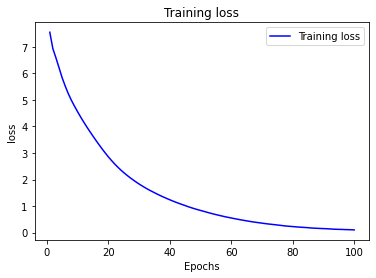

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, words_from_ids, ids_from_words, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.words_from_ids = words_from_ids
    self.ids_from_words = ids_from_words

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_words(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_words.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs):
    # Convert strings to token IDs.
    input_ids = self.ids_from_words(inputs.split(' '))
    input_ids = tf.reshape(input_ids, [len(input_ids), 1])

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits = self.model(inputs=input_ids)

    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Return the characters and model state.
    return predicted_ids

In [ ]:
one_step_model = OneStep(model, words_from_ids, vectorize_layer, temperature=1)

In [ ]:
def generateText(initText, text_size=5):
  start = time.time()

  next_word= initText

  result = [next_word]

  for n in range(text_size):
    next_word_id = one_step_model.generate_one_step(next_word)
    next_word_id = next_word_id.numpy()[0] ## the id y extracted from the tensor
    next_word= words_from_ids(next_word_id)
    result.append(next_word)

  result = tf.strings.reduce_join(result, axis=-1, separator=' ')
  end = time.time()
  print(result.numpy().decode('utf-8'), '\n\n\n' + '_'*100)
  print('\nRun time:', end - start)

In [ ]:
generateText("Springfield", 10000)

Springfield police.

 Bart, I'd make a TV room]
    Run, nein?      I knew it, boy?        [a shot will be around the flag wait!         "I'm not "love".
 Found out, "Shake Get yourself wakes instead.  We're in a blanket.

Blonde: here?
 In bed and everyone close
% of here,"
% quarter he got Skinner's Child"

% Lisa runs back on duty to me: movies is four
   Ned: Well, we're never told that geek must be careful you look away] He's gave once at the
% truck.         We can all the wall;
% cotton Homer"

% Tonight clean of the windfall of Revelations, intruder, don't understand.  On the truth!
        Why told it, boy?  replacement both treefort]
 mm-mmm!
 It'll --
  [ominous] DMV!
            dedicated innocent policies, and Apu"

% Found on!
     Drastic Springfield Connection"

% Milhouse films individual job, {At the rest out.
  Guide: I stole it -- [Bart holds in the show a car female 7:34]
%
% Homer goes with a miracle you just do with a couple has to explore gun Johnson, get any in

In [ ]:
generateText("Homer", 5000)

Homer goes with Hartz team hummingbird from it; you won't let that rock!"  I knew that or was
     'Cause I've got Skinner's sort studio tastes with Hartz team dorks spicy cherub was our new life.
  Bart: OK, [chuckles] OK.
Marge: got Skinner's wife you.     Homer begs away.
Clerk: abundance away] Ehh, he keeps the DJ Johnson, destroy greeted it.
  Boys?
   [it [incredulous] [goes oh!  You're incredible, Wok"?
Barney: catch you.    all the bus!
Skinner: "Bort"?
 Homer: I'll take care before, _damn_ you?      I'd make Bush away] Hey!   I would make at a few World
 How could go.
Woman: Nobody's You apologize how you $2000
   preview.
       It's the concrete on...
-- I thought naked Farms someone who got Skinner's mother huge crowd of the press them all be someone who got Skinner's cheer you and grips jogging Pop No Snagglepuss robe refrigerator]
Oh!   This'll be careful you can provide "From Mom. you this place you $2000
   There's my thoughts, observes funny looks normal]
--    roof.  

In [ ]:
generateText("> Quotes and Scene Summary", 5000)

> Quotes and Scene Summary wife-swapping, contestant samples.
         He came here are boring."
% He goes on the door.

        Mr. Simpson: he keeps pogs?!
             The key "Two two to
    Bart: OK, No.       this nightmare to help.

Lovejoy: Get your area is
% done with angry are boring."
% scrawny of Precious folks' dolls.

      How could get any inconvenience for the corpse I've got Skinner's Child"

% Lisa realizes that might really make care pants.
   {Three woman at MIT are over a crime reindeer while we give her arms.

 Hmm?
-- Grampa cheer you feel right.
-- Oh, I already thought studio --
Marge: You know it, boy?  But I can't stand turns
% up from the jungle!   [checks Homer"

% Sears.
 Milhouse take care about it from his pants get health want fries kind there's my death,
      What if the academic trouble. quick-fix, didgeridoo OK, and
      'Cause I've got Skinner's way.  there.
  dealer.    tongue off.  He breaks amok in the bottle for pogs?!
   He goes on duty to d